In [3]:
import re
import os
import numpy as np
import json

# Directorio donde están los archivos
directorio = os.path.join( "..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', "0covo")

# Expresión regular para buscar la línea con la energía total
patron_energia = r'Total PSPW energy\s*:\s*(-?\d+\.\d+E[+-]\d+)'

# Listas para almacenar distancias y energías
distancias = []
energias = []

# Verificar si el directorio existe
if not os.path.exists(directorio):
    print(f"El directorio {directorio} no existe. Verifica la ruta.")
    exit()

# Buscar todos los archivos en el directorio
archivos = os.listdir(directorio)

# Procesar cada archivo
for archivo in archivos:
    # Filtrar solo archivos que terminen en .out y comiencen con H2-
    if not (archivo.endswith('.out') and archivo.startswith('H1Li1-')):
        continue

    # Extraer la distancia del nombre del archivo (por ejemplo, H2-1.0.out -> 1.0)
    nombre = os.path.basename(archivo)
    try:
        distancia = float(nombre.replace('H1Li1-', '').replace('.out', ''))
        print(f"Procesando archivo: {nombre}, Distancia: {distancia}")  # Para depurar
    except ValueError:
        print(f'No se pudo extraer la distancia de {nombre}. Saltando...')
        continue

    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(directorio, archivo)

    # Leer el archivo y buscar la energía
    try:
        with open(ruta_archivo, 'r') as f:
            for linea in f:
                coincidencia = re.search(patron_energia, linea)
                if coincidencia:
                    energia = float(coincidencia.group(1))
                    distancias.append(distancia)
                    energias.append(energia)
                    print(f'Archivo: {nombre}, Distancia: {distancia}, Energía: {energia} Hartree')
                    break
            else:
                print(f'No se encontró la energía en {nombre}.')
    except FileNotFoundError:
        print(f'El archivo {ruta_archivo} no se encuentra.')
    except Exception as e:
        print(f'Error procesando {nombre}: {e}')

# Convertir arrays de NumPy a listas para JSON
distancias = np.array(distancias)
energias = np.array(energias)
sorted_indices = np.argsort(distancias)
distancias = distancias[sorted_indices].tolist()  # Convertir a lista
energias = energias[sorted_indices].tolist()      # Convertir a lista

# Imprimir resultados
print('\nResultados finales:')
print('Distancias:', distancias)
print('Energías:', energias)

# Estructurar datos para JSON
datos_json = {
    "0covo": [
        distancias,
        energias
    ]
}
with open('results_PW_LiH_HF.json', 'w') as f:
    json.dump(datos_json, f, indent=4)  
    

Procesando archivo: H1Li1-4.0.out, Distancia: 4.0
Archivo: H1Li1-4.0.out, Distancia: 4.0, Energía: -0.6363346488 Hartree
Procesando archivo: H1Li1-1.3.out, Distancia: 1.3
Archivo: H1Li1-1.3.out, Distancia: 1.3, Energía: -0.7262865716 Hartree
Procesando archivo: H1Li1-7.0.out, Distancia: 7.0
Archivo: H1Li1-7.0.out, Distancia: 7.0, Energía: -0.5799487248 Hartree
Procesando archivo: H1Li1-2.0.out, Distancia: 2.0
Archivo: H1Li1-2.0.out, Distancia: 2.0, Energía: -0.7345510884 Hartree
Procesando archivo: H1Li1-1.6.out, Distancia: 1.6
Archivo: H1Li1-1.6.out, Distancia: 1.6, Energía: -0.7444764614 Hartree
Procesando archivo: H1Li1-1.7.out, Distancia: 1.7
Archivo: H1Li1-1.7.out, Distancia: 1.7, Energía: -0.7443219888 Hartree
Procesando archivo: H1Li1-3.0.out, Distancia: 3.0
Archivo: H1Li1-3.0.out, Distancia: 3.0, Energía: -0.6792003826 Hartree
Procesando archivo: H1Li1-2.5.out, Distancia: 2.5
Archivo: H1Li1-2.5.out, Distancia: 2.5, Energía: -0.7069190178 Hartree
Procesando archivo: H1Li1-1.9.ou

In [47]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC

import pyscf
from pyscf import mcscf, ao2mo, fci



geometries = ["""Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;""", 
             """Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;""",
             """Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;""",
             """Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;""",
             """Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;""",
             """Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;""",
             """Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;""",
             """Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;""",
             """Li 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """Li 0.0 0.0 -2.00; H 0.0 0.0 2.00;""",
             """Li 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """Li 0.0 0.0 -2.50; H 0.0 0.0 2.50;""",
             """Li 0.0 0.0 -3.00; H 0.0 0.0 3.00;""",
             """Li 0.0 0.0 -3.50; H 0.0 0.0 3.50;""",]#Angstrom

results_LiH = []

basis = "cc-pvdz"
cas = (4, 10) # active space
unit = "angstrom"  #angstrom, bohr

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)
    #### SlowQuant
    SQobj = sq.SlowQuant()
    SQobj.set_molecule(geometry, distance_unit=unit,)
    SQobj.set_basis_set(basis)

    #### PySCF
    mol = pyscf.M(atom = geometry, basis = basis, unit = unit)

    mf = mol.RHF().run()

    energy_HF = mf.e_tot

    #### HF 
    mo_coeffs = mf.mo_coeff #this has size (19,19)
    
    ## Control how many orbitals we wanna use in our calculations
    norb_act = 10
    mo_coeffs_act = mo_coeffs[:, :norb_act]
    
    #### get the integrals in the AO basis
    hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
    eri_4fold_ao = mol.intor('int2e_sph')
    
    hcore_ao_act = hcore_ao[:norb_act, :norb_act]
    eri_4fold_ao_act = eri_4fold_ao[:norb_act, :norb_act, :norb_act, :norb_act]

    # OO-UCCSD
    WF = WaveFunctionUCC(
    num_elec=SQobj.molecule.number_electrons,
    cas=cas,
    mo_coeffs=mo_coeffs,
    h_ao=hcore_ao,
    g_ao=eri_4fold_ao,
    excitations="SD",
    include_active_kappa=True,
    )
    
    WF.run_wf_optimization_1step(
    		optimizer_name="SLSQP", 
    		tol = 1e-6,
    		orbital_optimization=False)

    energy_uccsd = WF.energy_elec + mol.energy_nuc()

    fcisolver = fci.FCI(mf)
    energy_fci, fci_vector = fcisolver.kernel()
    
    norb_fci = fcisolver.norb
    print(f'Number of orbitals used in FCI: {norb_fci}')
    print(f"Hartree-Fock energy for geometry {i+1} = {energy_HF}")
    print(f"UCCSD energy for geometry {i+1} = {energy_uccsd}")
    print(f"FCI energy for geometry {i+1} = {energy_fci}")
      
    results_LiH.append({
        'geometry': geometry,
        'energy HF': energy_HF,
        'energy uccsd': energy_uccsd,
        'energy fci': energy_fci,
        'nuclear_repulsion': mol.energy_nuc(),
        'electronic_energy': WF.energy_elec
    })

with open('results_pvdz_LiH_4.json', 'w') as f:
    json.dump(results, f, indent=4)  



Processing geometry 1:
Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;
converged SCF energy = -7.96601167739468
### Parameters information:
### Number kappa: 0
### Number theta1: 16
### Number theta2: 136
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 152

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |        27.86       |     -9.1795986793101925    
Number of orbitals used in FCI: 19
Hartree-Fock energy for geometry 1 = -7.966011677394681
UCCSD energy for geometry 1 = -7.96828775605408
FCI energy for geometry 1 = -7.999100857546528

Processing geometry 2:
Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;
converged SCF energy = -7.97635394267362
### Parameters information:
### Number kappa: 0
### Number theta1: 16
### Number theta2: 136
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 152

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------   

TypeError: Object of type ndarray is not JSON serializable

In [1]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import matplotlib.pyplot as plt
import pyscf
from pyscf import mcscf, ao2mo, fci
#ccpvtz, ccpvqz

geometries = ["""Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;""", 
             """Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;""",
             """Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;""",
             """Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;""",
             """Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;""",
             """Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;""",
             """Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;""",
             """Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;""",
             """Li 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """Li 0.0 0.0 -2.00; H 0.0 0.0 2.00;""",
             """Li 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """Li 0.0 0.0 -2.50; H 0.0 0.0 2.50;""",
             """Li 0.0 0.0 -3.00; H 0.0 0.0 3.00;""",
             """Li 0.0 0.0 -3.50; H 0.0 0.0 3.50;""",]#Angstrom

distances = [1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0 ]  

basis = ["cc-pvdz", "cc-pvtz"]
results = {base: {} for base in basis}
active_spaces = [3, 6, 10, 14, 20]

unit= "angstroms"
for base in (basis):
    for i, geometry in enumerate(geometries):
       
        mol = pyscf.M(atom = geometry, basis = base, unit = unit)
        mf = mol.RHF().run()

        energy_HF = mf.e_tot

        fcisolver = fci.FCI(mf)
    
        energy_fci, fci_vector = fcisolver.kernel()
        norb_fci = fcisolver.norb

        distance = str(distances[i])  
        results[base][distance] = {
            "HF": energy_HF,
            "FCI": energy_fci,
            "N_orb": norb_fci
        }
        
        # Imprimir progreso (opcional)
        print(f"Base: {base}, Distance: {distance} Å, HF: {energy_HF:.8f}, FCI: {energy_fci:.8f}, N_orb: {norb_fci:.8f}")
        
        for ncas in active_spaces:
            if ncas <= norb_fci:
                mycas = mf.CASSCF(ncas, 4)

                mycas.frozen = [0,1]
                
                mycas.run()

                energy_casscf = mycas.e_tot

                results[base][distance][f"CASSCF_{ncas}"] = energy_casscf
            
                print(f"Base: {base}, Distance: {distance} Å, CASSCF({2},{ncas}): {energy_casscf:.8f}")  


# Guardar resultados en archivo JSON
output_file = "energies_lih_atomic.json"
try:
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Resultados guardados exitosamente en {output_file}")
except Exception as e:
    print(f"Error al guardar el archivo JSON: {e}")

converged SCF energy = -7.96601167739467
Base: cc-pvdz, Distance: 1.3 Å, HF: -7.96601168, FCI: -7.99910086, N_orb: 19.00000000
CASSCF energy = -7.98139715428743
CASCI E = -7.98139715428743  E(CI) = -9.20257533333358  S^2 = 0.0000000
Base: cc-pvdz, Distance: 1.3 Å, CASSCF(2,3): -7.98139715
CASSCF energy = -7.99663515525934
CASCI E = -7.99663515525934  E(CI) = -9.21781333430549  S^2 = 0.0000000
Base: cc-pvdz, Distance: 1.3 Å, CASSCF(2,6): -7.99663516
CASSCF energy = -7.99892036299450
CASCI E = -7.99892036299450  E(CI) = -9.22009854204065  S^2 = 0.0000000
Base: cc-pvdz, Distance: 1.3 Å, CASSCF(2,10): -7.99892036
CASSCF energy = -7.99905457630847
CASCI E = -7.99905457630847  E(CI) = -9.22023275535462  S^2 = 0.0000000
Base: cc-pvdz, Distance: 1.3 Å, CASSCF(2,14): -7.99905458
converged SCF energy = -7.97635394267362
Base: cc-pvdz, Distance: 1.4 Å, HF: -7.97635394, FCI: -8.00828334, N_orb: 19.00000000
CASSCF energy = -7.99168030183005
CASCI E = -7.99168030183005  E(CI) = -9.12563146808719  S^

In [4]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci
import matplotlib.pyplot as plt
import numpy as np


covos = [1, 4, 8, 12, 18]

for covo in covos:
    print('{} COVOs'.format(covo))
    data_dir_nwchem = os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem','{}covo'.format(covo))
    data_dir_yaml = os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', '{}covo_yaml'.format(covo))
    if not os.path.exists(data_dir_yaml):
        os.makedirs(os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', '{}covo_yaml'.format(covo)))
    data_files = os.listdir(data_dir_nwchem)
    bond_distances = []

    for data_file in data_files:
        if data_file.find('out') == -1:
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        name = temp[0] + '-' + str(bond_distance)
        print("========= Bond distance: {} =========".format(bond_distance))
        data_file_yaml = os.path.join(data_dir_yaml, "{}.yaml".format(name))  # create the empty .yaml file in data_dir_yaml   
        
        data = extract_fields(os.path.join(data_dir_nwchem,data_file)) # data extracts the information from the output file 
        
        with open(data_file_yaml, 'w') as f:
            f.write(yaml.dump(data, default_flow_style=False)) # we write the extracted data into the .yaml file so we can work with it
            

1no COVOs
========= Bond distance: 4.0 =========
========= Bond distance: 1.3 =========
========= Bond distance: 7.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 1.6 =========
========= Bond distance: 1.7 =========
========= Bond distance: 3.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 1.9 =========
========= Bond distance: 5.0 =========
========= Bond distance: 1.5 =========
========= Bond distance: 1.4 =========
========= Bond distance: 4.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 3.5 =========
========= Bond distance: 1.8 =========
4no COVOs
========= Bond distance: 4.0 =========
========= Bond distance: 1.3 =========
========= Bond distance: 7.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 1.6 =========
========= Bond distance: 1.7 =========
========= Bond distance: 3.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 1.9 =========
=====

In [5]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
import pyscf
from pyscf import fci, mcscf, ao2mo
import matplotlib.pyplot as plt
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
from qiskit_nwchem_driver import customized_exp_kappa as kappa

# In this cell we run FCI and UCCSD for COVO. Computationally expensive for >12 COVO

fcisolver = fci.direct_spin1.FCI()

covos = [1,4,8,12,18]

data_covos={}
for covo in covos:
    print(f'{covo} COVOs')
    data_dir_yaml = os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', '{}nocovo_yaml'.format(covo))
    data_files = os.listdir(data_dir_yaml)
    bond_distances = []
    total_energies_uccsd = []
    total_energies_fci = []
    
    for data_file in data_files:
        if not data_file.endswith('.yaml'):
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        print(f"========= Bond distance: {bond_distance} =========")      
        yaml_file = os.path.join(data_dir_yaml, data_file)
        driver = nwchem_driver.NWchem_Driver(yaml_file)
        n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(yaml_file, include_spin=False)

        WF = WaveFunctionUCC(
             num_elec=n_electrons,
             cas=(2,n_spatial_orbitals),
             mo_coeffs=np.identity(n_spatial_orbitals),
             #c_orthonormal = random_start_guess, 
             h_ao=h1,
             g_ao=h2,
             excitations="SD",
             include_active_kappa=True,
             )
        
       # WF.run_wf_optimization_1step(
       #      optimizer_name="SLSQP", 
       	#     tol = 1e-5,
       	#	 orbital_optimization=False)
        
        energy_fci, ci_vec = fcisolver.kernel(h1e=h1, eri=h2, norb=n_spatial_orbitals, nelec=n_electrons)      

        #total_energies_uccsd.append(WF.energy_elec + nuclear_repulsion_energy)
        total_energies_fci.append(energy_fci + nuclear_repulsion_energy)
        
        #print(f"UCCSD energy = {WF.energy_elec + nuclear_repulsion_energy}")
        print(f"FCI energy = {energy_fci  + nuclear_repulsion_energy}")
       
   # total_energies_uccsd = np.array(total_energies_uccsd)
    bond_distances = np.array(bond_distances)
    total_energies_fci = np.array(total_energies_fci)

    sorted_indices = np.argsort(bond_distances)
    bond_distances = bond_distances[sorted_indices]
    #total_energies_uccsd = total_energies_uccsd[sorted_indices]
    total_energies_fci = total_energies_fci[sorted_indices]
#total_energies_uccsd.tolist(),
    data_covos[covo] = [bond_distances.tolist(), total_energies_fci.tolist()]

with open('results_nocovo_LiH_FCI.json', 'w') as f:
     json.dump(data_covos, f, indent=4)  

1 COVOs
========= Bond distance: 2.5 =========
FCI energy = -0.70711587292385
========= Bond distance: 1.8 =========
FCI energy = -0.7423230747337723
========= Bond distance: 3.0 =========
FCI energy = -0.6797670418860895
========= Bond distance: 1.5 =========
FCI energy = -0.7421193818338159
========= Bond distance: 1.3 =========
FCI energy = -0.7262970437872351
========= Bond distance: 4.5 =========
FCI energy = -0.633453023458602
========= Bond distance: 6.0 =========
FCI energy = -0.6426122479300003
========= Bond distance: 1.7 =========
FCI energy = -0.744349747741518
========= Bond distance: 4.0 =========
FCI energy = -0.6408933274205321
========= Bond distance: 7.0 =========
FCI energy = -0.6482799288399999
========= Bond distance: 3.5 =========
FCI energy = -0.6571450308737528
========= Bond distance: 5.0 =========
FCI energy = -0.6340279399728359
========= Bond distance: 1.4 =========
FCI energy = -0.7364100109571308
========= Bond distance: 1.9 =========
FCI energy = -0.73894

In [ ]:
import pyscf
import numpy as np
import json
from pyscf import fci
from pyscf import mcscf, ao2mo, fci, scf
from pyscf import gto
import matplotlib.pyplot as plt
from pyscf.pbc import gto as pbcgto


geometries = ["""Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;""", 
             """Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;""",
             """Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;""",
             """Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;""",
             """Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;""",
             """Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;""",
             """Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;""",
             """Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;""",
             """Li 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """Li 0.0 0.0 -2.00; H 0.0 0.0 2.00;""",
             """Li 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """Li 0.0 0.0 -2.50; H 0.0 0.0 2.50;""",
             """Li 0.0 0.0 -3.00; H 0.0 0.0 3.00;""",
             """Li 0.0 0.0 -3.50; H 0.0 0.0 3.50;""",]#Angstrom

   
basis = ["cc-pv5z","aug-cc-pvqz"]
unit = "angstrom"  #angstrom, bohr
results = {base: {} for base in basis}

distances = [1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0 ]  

for base in (basis):
    for i, geometry in enumerate(geometries):
        print(f"\nProcessing geometry {i+1}:")
        print(geometry)

        mol_pseudo = pyscf.M(atom=geometry, basis=base, unit=unit, pseudo='ccecp')

        mf_pseudo = mol_pseudo.RHF().run()

        energy_HF_pseudo = mf_pseudo.e_tot
    
        fcisolver = fci.FCI(mf_pseudo)
    
        energy_fci_pseudo, _ = fcisolver.kernel()
        norb_fci_pseudo = fcisolver.norb

        distance = str(distances[i])  
        results[base][distance] = {
                "HF": energy_HF_pseudo,
                "FCI": energy_fci_pseudo,
                "N_orb": norb_fci_pseudo
            }
        print(f"Base: {base}, Distance: {distance} Å, HF: {energy_HF_pseudo:.8f}, FCI: {energy_fci_pseudo:.8f}")

with open('results_pseudo_LiH_extra.json', 'w') as f:
     json.dump(results, f, indent=4)  



Processing geometry 1:
Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;
converged SCF energy = -0.734208748454874
Base: cc-pv5z, Distance: 1.3 Å, HF: -0.73420875, FCI: -0.77219114

Processing geometry 2:
Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;
converged SCF energy = -0.743724800909202
Base: cc-pv5z, Distance: 1.4 Å, HF: -0.74372480, FCI: -0.78131512

Processing geometry 3:
Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;
converged SCF energy = -0.748563050569288
Base: cc-pv5z, Distance: 1.5 Å, HF: -0.74856305, FCI: -0.78591734

Processing geometry 4:
Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;
converged SCF energy = -0.750029490616585


In [2]:
import json
#Load results UCCSD & FCI for COVO
with open('results_covo_LiH.json', 'r') as f:
    energies_covo_LiH = json.load(f)
#Load results HF for PW
with open('results_PW_LiH_HF.json', 'r') as f:
    energies_PW_LiH_HF = json.load(f)
#Load results for FCI PW no COVO
with open('results_nocovo_LiH_FCI.json', 'r') as f:
    energies_nocovo_LiH_FCI = json.load(f)
#Load results HF & FCI for Atomic Orbitals
with open('energies_lih_atomic.json', 'r') as f:
    energies_lih_atomic = json.load(f)
#Load results HF & FCI for Pseudopotential Atomic Orbitals
with open('results_pseudo_LiH.json', 'r') as f:
    energies_lih_pseudo = json.load(f)

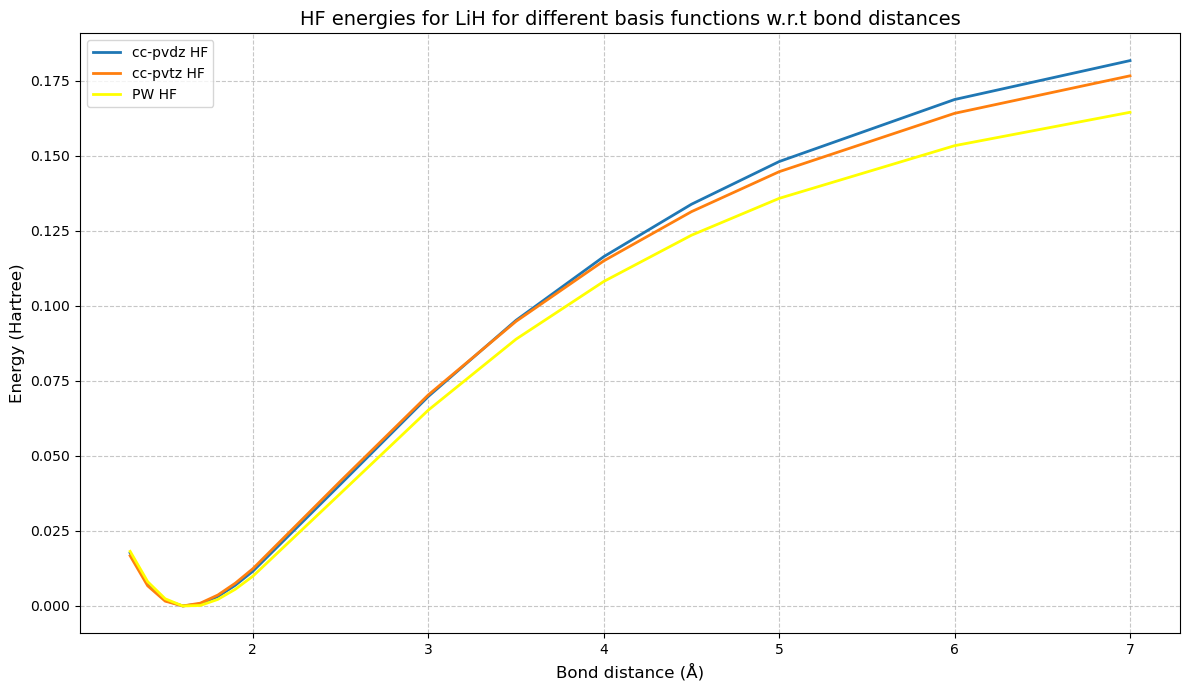

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np



bases = list(energies_lih_atomic.keys())  

distancias = [float(d) for d in energies_lih_atomic[bases[0]].keys()]
distancias.sort()  # Ordenar numéricamente

plt.figure(figsize=(12, 7))

for i, base in enumerate(bases):
    energias_hf = [energies_lih_atomic[base][str(d)]["HF"] for d in distancias]
    energia_min = min(energias_hf)
    energias_hf_normalizadas = [e - energia_min for e in energias_hf]
    #energias_fci = [energies_h2_atomic[base][str(d)]["FCI"] for d in distancias]
    
    plt.plot(distancias, energias_hf_normalizadas, label=f"{base} HF", linewidth=2)
    
    #plt.plot(distancias, energias_fci, label=f"{base} FCI", linewidth=2)
energias_pw = energies_PW_LiH_HF['0covo'][1]
energia_min_pw = min(energias_pw)
energias_pw_normalizadas = [e - energia_min_pw for e in energias_pw]
plt.plot(distancias, energias_pw_normalizadas, color='yellow', label="PW HF", linewidth=2)
plt.xlabel("Bond distance (Å)", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.title("HF energies for LiH for different basis functions w.r.t bond distances", fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(min(distancias), max(distancias))
#plt.ylim(-2.0, -0.5)  # Descomenta y ajusta si necesitas
plt.tight_layout()
plt.savefig("energies_hf_lih_covo.png", dpi=300, bbox_inches='tight')
plt.show()

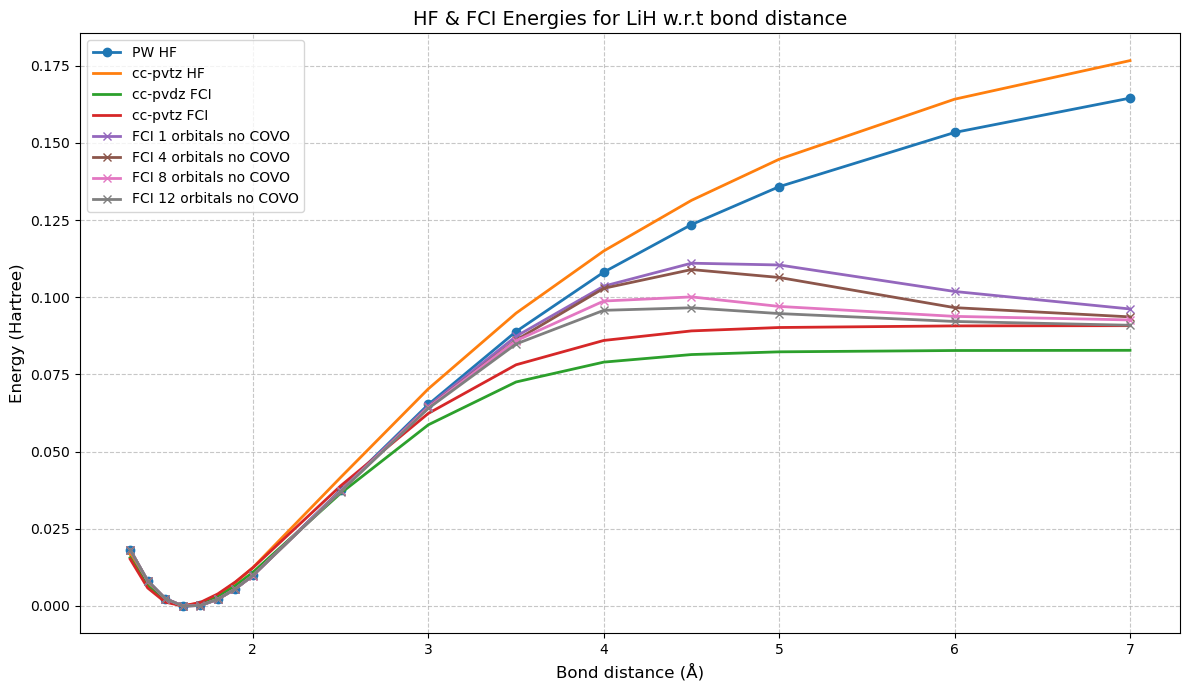

In [6]:
plt.figure(figsize=(12, 7))

energias_pw = energies_PW_LiH_HF['0covo'][1]
energia_min_pw = min(energias_pw)
energias_pw_normalizadas = [e - energia_min_pw for e in energias_pw]

plt.plot(distancias, energias_pw_normalizadas, 'o-', label="PW HF", linewidth=2)

energia_hf = [energies_lih_atomic['cc-pvtz'][str(d)]["HF"] for d in distancias]
energia_min = min(energias_hf)
energias_hf_normalizadas = [e - energia_min for e in energias_hf]
plt.plot(distancias, energias_hf_normalizadas, label=f"{'cc-pvtz'} HF", linewidth=2)

for i, base in enumerate(bases):

    energias_fci = [energies_lih_atomic[base][str(d)]["FCI"] for d in distancias]
    energia_min = min(energias_fci)
    energias_fci_normalizadas = [e - energia_min for e in energias_fci]
    plt.plot(distancias, energias_fci_normalizadas, label=f"{base} FCI", linewidth=2)
    
for covo in energies_covo_LiH:
    energias_fci_nocovo = energies_nocovo_LiH_FCI[covo][1]
    energia_min = min(energias_fci_nocovo)
    energias_fci_nocovo_normalizadas = [e - energia_min for e in energias_fci_nocovo]
    plt.plot(energies_covo_LiH[covo][0], energias_fci_nocovo_normalizadas ,'x-', label=f'FCI {covo} orbitals no COVO', linewidth=2)

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('HF & FCI Energies for LiH w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("energies_fci_lih_nocovo.png", dpi=300, bbox_inches='tight')
plt.show()

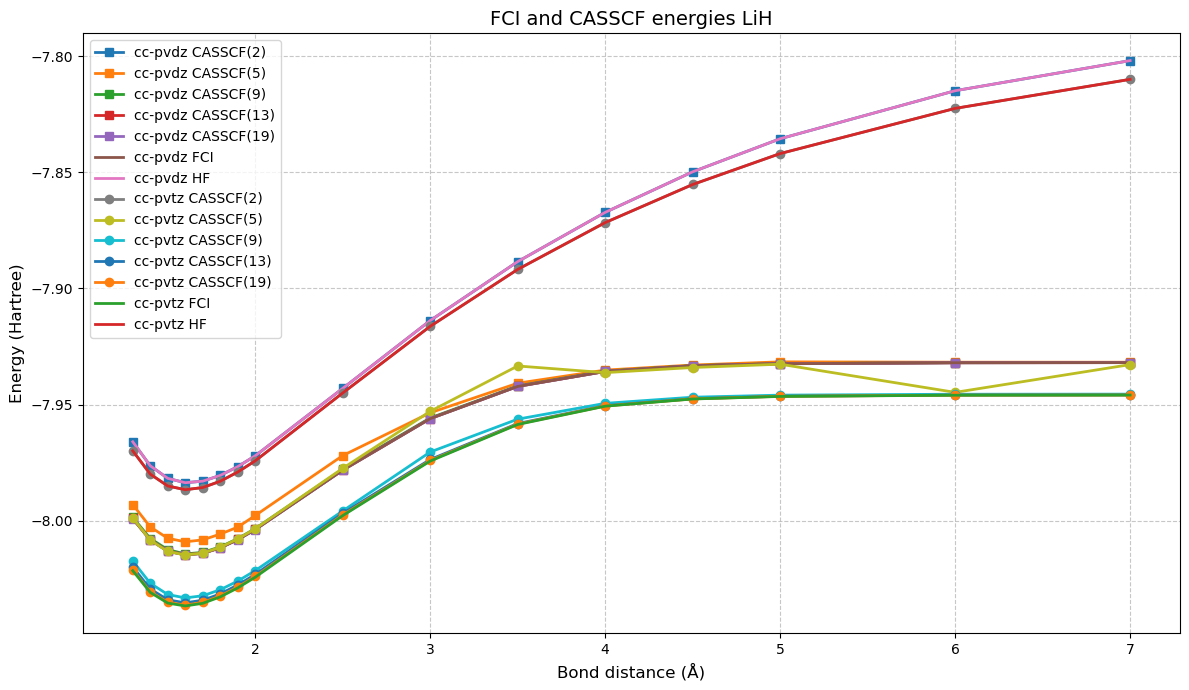

In [16]:
plt.figure(figsize=(12, 7))
marker=['s','o']
for i, base in enumerate(bases):
    for ncas in [2, 5, 9, 13, 19]:
        energias_casscf = [energies_lih_atomic[base][str(d)][f"CASSCF_{ncas}"] for d in distancias]

        plt.plot(distancias, energias_casscf, marker=marker[i], label=f"{base} CASSCF({ncas})", linewidth=2)

    energias_fci = [energies_lih_atomic[base][str(d)]["FCI"] for d in distancias]
    energias_HF = [energies_lih_atomic[base][str(d)]["HF"] for d in distancias]

    plt.plot(distancias, energias_fci, label=f"{base} FCI", linewidth=2)
    plt.plot(distancias, energias_HF, label=f"{base} HF", linewidth=2)



plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI and CASSCF energies LiH',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("test.png", dpi=300, bbox_inches='tight')
plt.show()

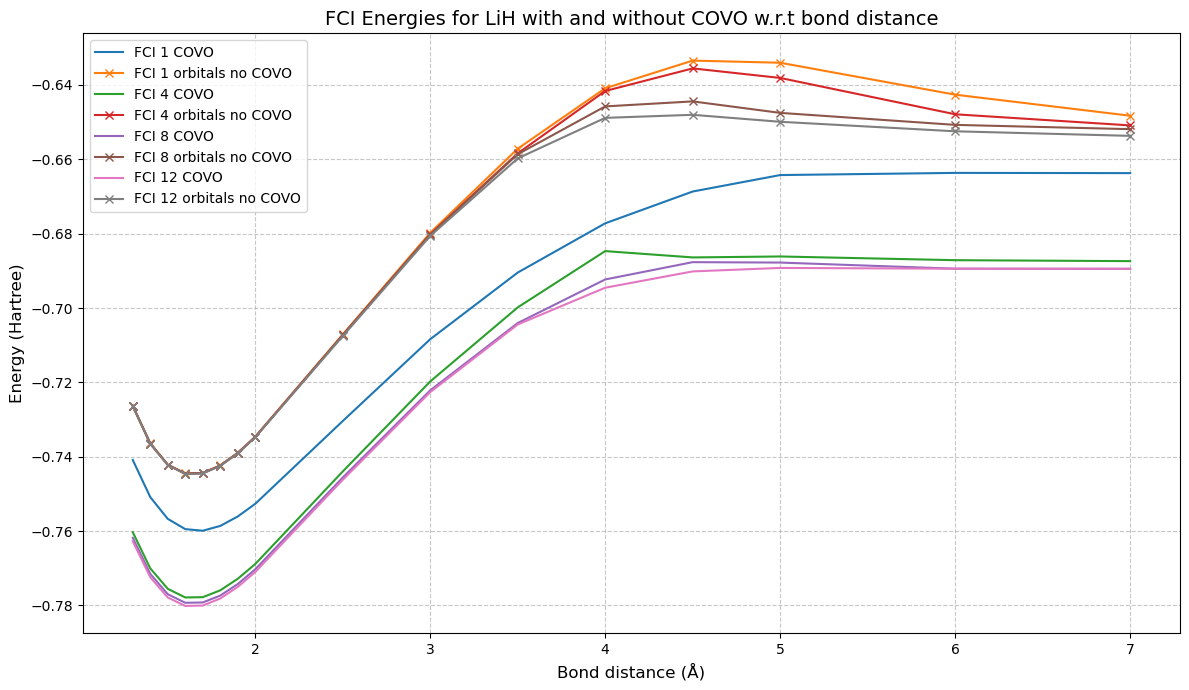

In [42]:
plt.figure(figsize=(12, 7))

for covo in energies_covo_LiH:
    plt.plot(energies_covo_LiH[covo][0], energies_covo_LiH[covo][2], label=f'FCI {covo} COVO')
    plt.plot(energies_covo_LiH[covo][0], energies_nocovo_LiH_FCI[covo][1] ,'x-', label=f'FCI {covo} orbitals no COVO')

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI Energies for LiH with and without COVO w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("energies_fci_lih_covo.png", dpi=300, bbox_inches='tight')
plt.show()

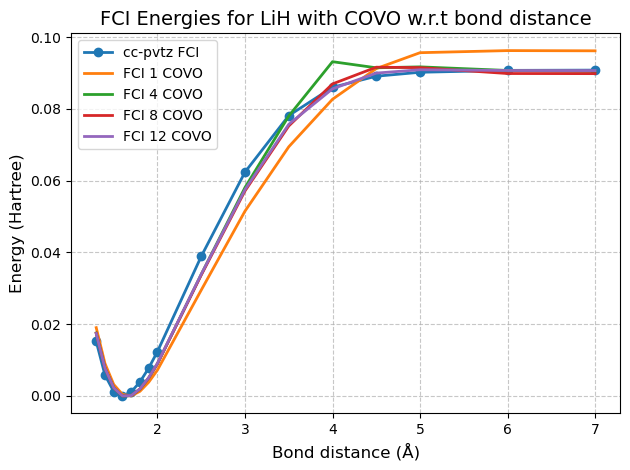

In [8]:
energia_fci = [energies_lih_atomic['cc-pvtz'][str(d)]["FCI"] for d in distancias]
energia_min = min(energia_fci)
energias_fci_normalizadas = [e - energia_min for e in energia_fci]
plt.plot(distancias, energias_fci_normalizadas, 'o-', label=f"{'cc-pvtz'} FCI", linewidth=2)

for covo in energies_covo_LiH:
    energias_fci_covo = energies_covo_LiH[covo][2]
    energia_min = min(energias_fci_covo)
    energias_fci_covo_normalizadas = [e - energia_min for e in energias_fci_covo]
    plt.plot(energies_covo_LiH[covo][0], energias_fci_covo_normalizadas, label=f'FCI {covo} COVO', linewidth=2)

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI Energies for LiH with COVO w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.177,-1.05])
#plt.xlim([0.5,1.5])
#plt.ylim([-1.05,-0.970])
#plt.xlim([1.5,3.0])
#plt.ylim([-1.001,-0.979])
#plt.xlim([3.0,6.0])
plt.tight_layout()
plt.savefig("energies_fci_lih_covo_zoom.png", dpi=300, bbox_inches='tight')
plt.show()

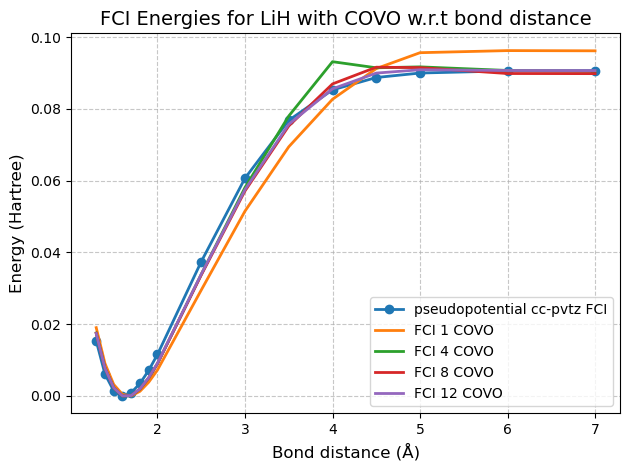

In [15]:
energia_fci = [energies_lih_pseudo[str(d)]["FCI"] for d in distancias]
energia_min = min(energia_fci)
energias_fci_normalizadas = [e - energia_min for e in energia_fci]
plt.plot(distancias, energias_fci_normalizadas, 'o-', label=f"pseudopotential {'cc-pvtz'} FCI", linewidth=2)

for covo in energies_covo_LiH:
    energias_fci_covo = energies_covo_LiH[covo][2]
    energia_min = min(energias_fci_covo)
    energias_fci_covo_normalizadas = [e - energia_min for e in energias_fci_covo]
    plt.plot(energies_covo_LiH[covo][0], energias_fci_covo_normalizadas, label=f'FCI {covo} COVO', linewidth=2)

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI Energies for LiH with COVO w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.177,-1.05])
#plt.xlim([0.5,1.5])
#plt.ylim([-1.05,-0.970])
#plt.xlim([1.5,3.0])
#plt.ylim([-1.001,-0.979])
#plt.xlim([3.0,6.0])
plt.tight_layout()
plt.savefig("energies_fci_lih_covo_zoom_pseudo.png", dpi=300, bbox_inches='tight')
plt.show()

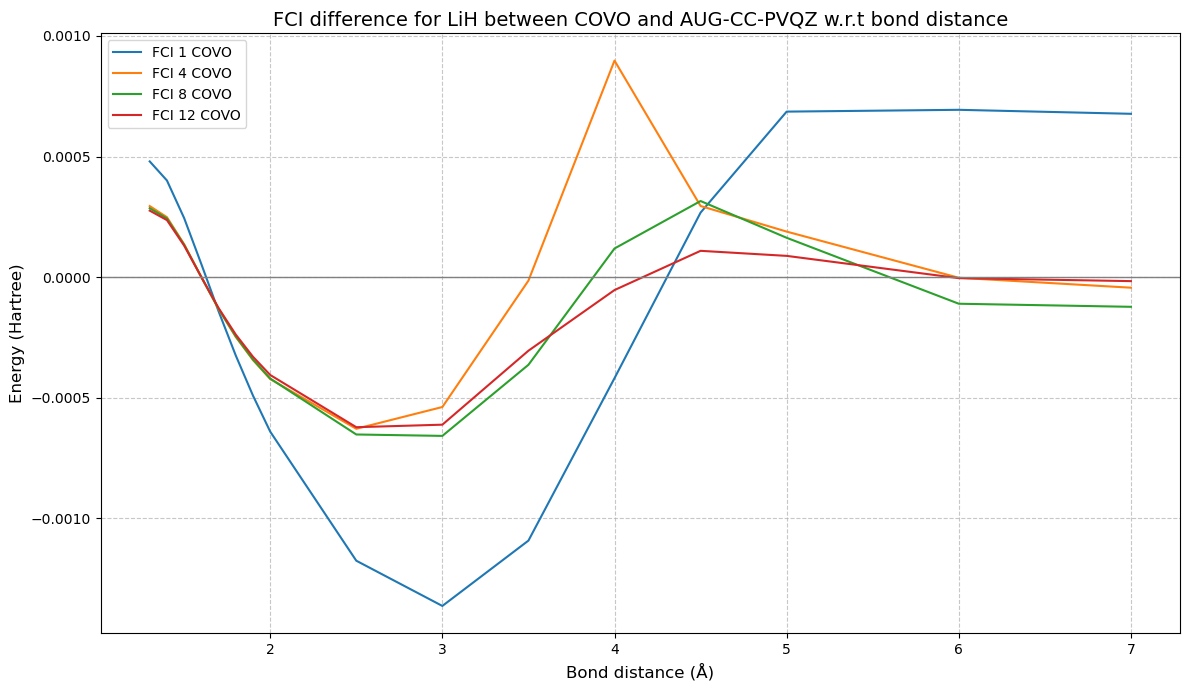

In [44]:
errors_uccsd_LiH = {}
errors_fci_LiH = {}

energia_fci = [energies_lih_atomic['cc-pvtz'][str(d)]["FCI"] for d in distancias]
energia_min = min(energia_fci)
energias_fci_normalizadas = [e - energia_min for e in energias_fci]
energias_fci_normalizadas = np.array(energias_fci_normalizadas)
plt.figure(figsize=(12, 7))

for covo in energies_covo_LiH:
    energias_fci_covo = energies_covo_LiH[covo][2]
    energia_min = min(energias_fci_covo)
    energias_fci_covo_normalizadas = [e - energia_min for e in energias_fci_covo]
    errors_fci_LiH[covo] = (energias_fci_covo_normalizadas - energias_fci_normalizadas)/np.abs(energia_fci)
    plt.plot(energies_covo_LiH[covo][0], errors_fci_LiH[covo],  label=f'FCI {covo} COVO')  

plt.axhline(0, color='gray', linestyle='-', linewidth=1) 

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI difference for LiH between COVO and AUG-CC-PVQZ w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("error_covo_lih.png", dpi=300, bbox_inches='tight')
plt.show()

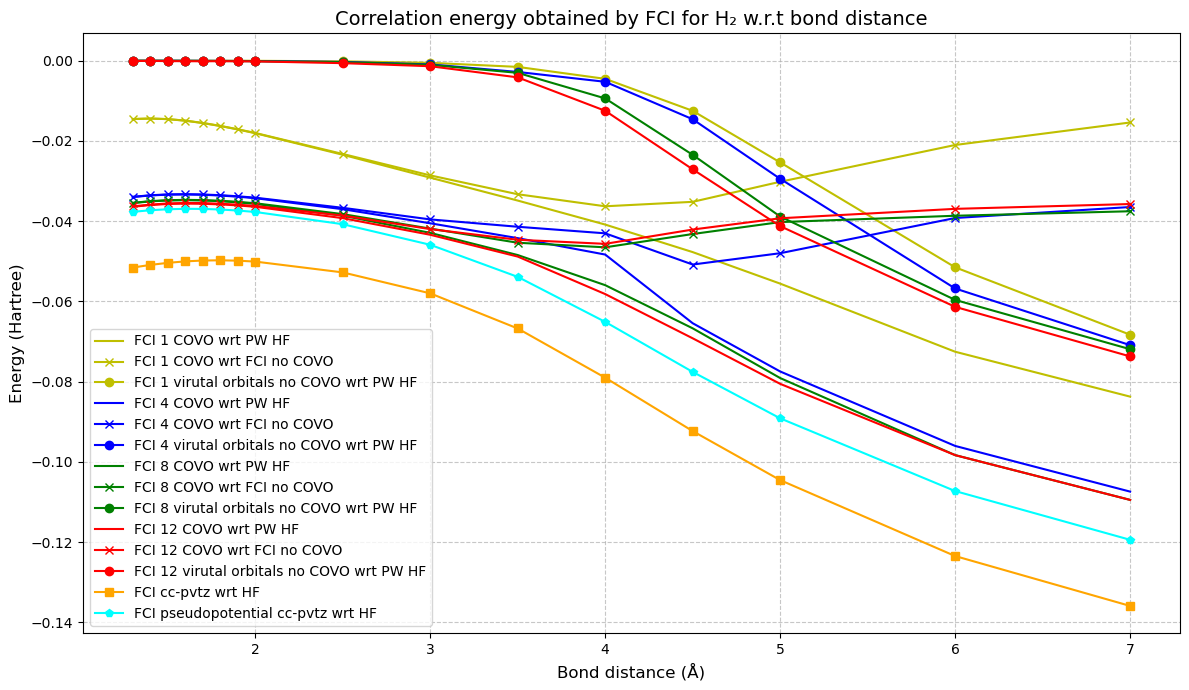

In [16]:
colors = ['y','b','g','r','c','m','k']
plt.figure(figsize=(12, 7))
distancias = [float(d) for d in energies_lih_atomic[bases[0]].keys()]
distancias.sort()  # Ordenar numéricamente
for i,covo in enumerate (energies_covo_LiH):
    plt.plot(energies_covo_LiH[covo][0], np.array(energies_covo_LiH[covo][2]) - energies_PW_LiH_HF['0covo'][1],color=colors[i], label = f'FCI {covo} COVO wrt PW HF')
    plt.plot(energies_covo_LiH[covo][0], np.array(energies_covo_LiH[covo][2]) - energies_nocovo_LiH_FCI[covo][1],color=colors[i], marker='x', label = f'FCI {covo} COVO wrt FCI no COVO')
    plt.plot(energies_covo_LiH[covo][0], np.array(energies_nocovo_LiH_FCI[covo][1]) - energies_PW_LiH_HF['0covo'][1],color=colors[i], marker='o', label = f'FCI {covo} virutal orbitals no COVO wrt PW HF')
    
plt.plot(energies_covo_LiH[covo][0], np.array([energies_lih_atomic[base][str(d)]["FCI"] for d in distancias]) - [energies_lih_atomic['cc-pvtz'][str(d)]["HF"] for d in distancias], color='orange', marker='s',label='FCI cc-pvtz wrt HF')
plt.plot(energies_covo_LiH[covo][0], np.array([energies_lih_pseudo[str(d)]["FCI"] for d in distancias]) - [energies_lih_pseudo[str(d)]["HF"] for d in distancias], color='cyan', marker='p',label='FCI pseudopotential cc-pvtz wrt HF')

plt.grid(True)
plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('Correlation energy obtained by FCI for H₂ w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.001,-0.979])
#plt.xlim([2.0,6.0])
plt.savefig('correlation_covo_lih.png')
plt.tight_layout()
plt.show()

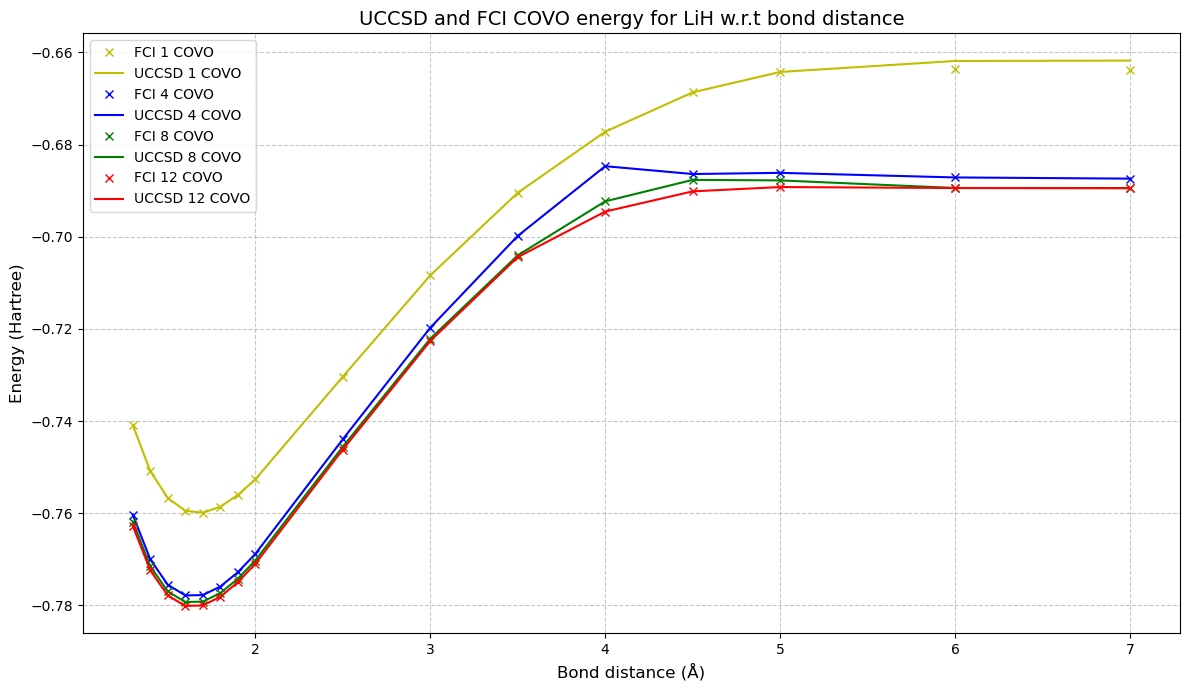

In [46]:

plt.figure(figsize=(12, 7))
colors = ['y','b','g','r','c','m','k']
for i,covo in enumerate (energies_covo_LiH):
    plt.plot(energies_covo_LiH[covo][0], energies_covo_LiH[covo][2], color=colors[i],linestyle='', marker='x', label = f'FCI {covo} COVO')
    plt.plot(energies_covo_LiH[covo][0], energies_covo_LiH[covo][1], color=colors[i], label = f'UCCSD {covo} COVO')

plt.grid(True)
plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('UCCSD and FCI COVO energy for LiH w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.001,-0.979])
#plt.xlim([2.0,6.0])
plt.savefig('energy_fci_uccsd_covo_lih.png')
plt.tight_layout()
plt.show()

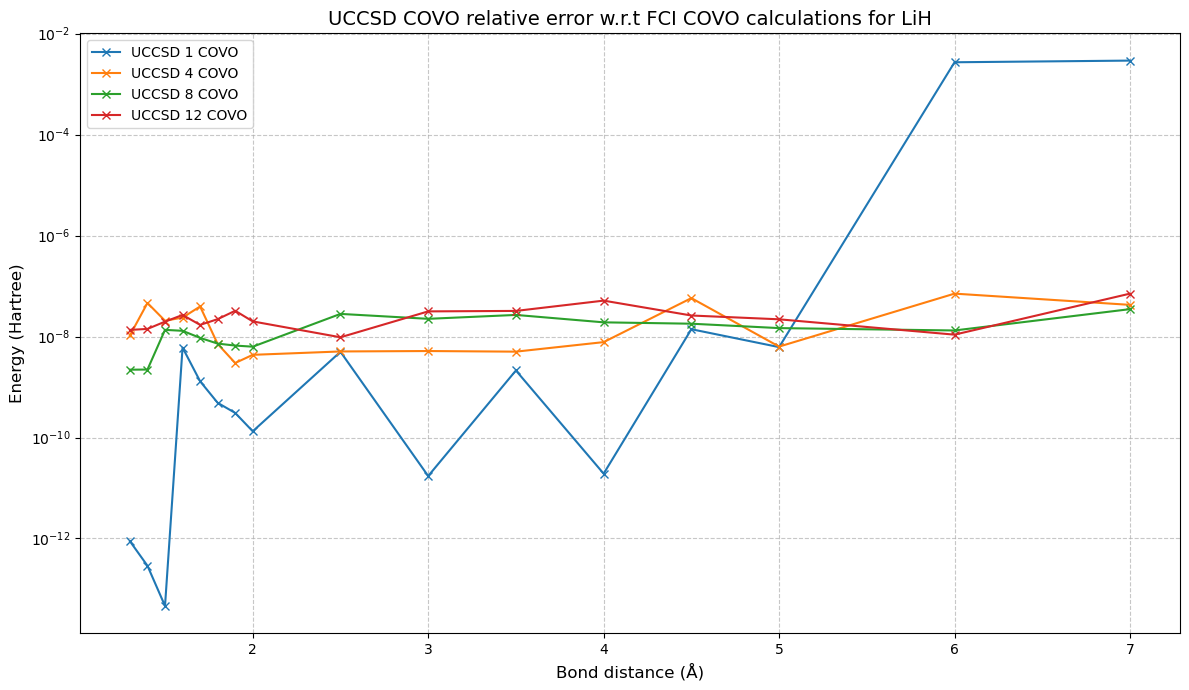

In [47]:
error_covos = {}

for covo in energies_covo_LiH:
    
    energy_covo_uccsd = np.array(energies_covo_LiH[covo][1])
    energy_covo_fci = np.array(energies_covo_LiH[covo][2])
    
    error_covos[covo] = np.abs(energy_covo_uccsd - energy_covo_fci)/np.abs(energy_covo_fci)
plt.figure(figsize=(12, 7))
    
for covo in energies_covo_LiH:
    plt.semilogy(energies_covo_LiH[covo][0], error_covos[covo], 'x-', label = f'UCCSD {covo} COVO')
plt.grid(True)
plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('UCCSD COVO relative error w.r.t FCI COVO calculations for LiH',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('error_covo_uccsd_lih.png')
plt.tight_layout()
plt.show()

